In [1]:
import numpy as np
import cv2 as cv
import csv
import matplotlib.pyplot as plt
from PIL import Image

### Decoding RLEs into masks for training

In [2]:
def decode_rle_to_mask(rle, height, width, viz=False):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask 
    width : width of the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width, 1, 3))
    if viz:
        color = np.random.rand(3)
    else:
        color = [1,1,1]
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1]), :, :] = color

    return mask.reshape(height, width, 3)

In [3]:
# Open train file
with open('/kaggle/input/Multiclass-segmentation/train.csv', 'r', encoding='utf-8') as train:
    reader = csv.reader(train)
    # skip headers row
    next(reader)

    # pull the masks for the first image
    row = next(iter(reader))
    print(row[0])
    mask1 = decode_rle_to_mask(row[4],int(row[1]), int(row[2]))
    row = next(iter(reader))
    mask2 = decode_rle_to_mask(row[4],int(row[1]), int(row[2]))
    row = next(iter(reader))
    mask3 = decode_rle_to_mask(row[4],int(row[1]), int(row[2]))    

2008_006280


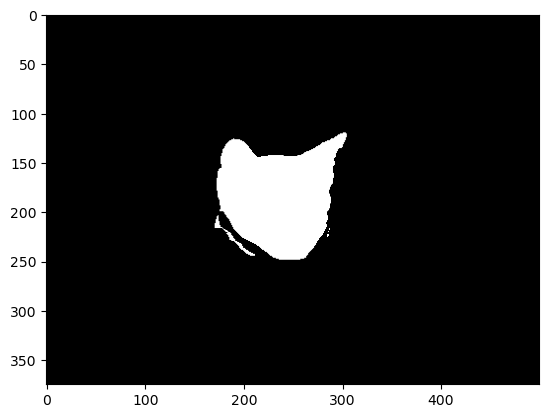

In [4]:
# Head mask
plt.imshow(mask1)

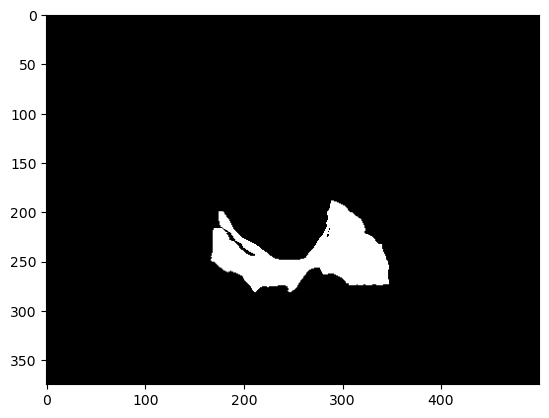

In [5]:
# Body mask
plt.imshow(mask2)

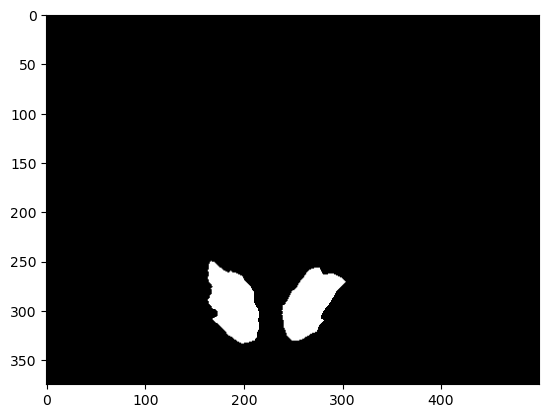

In [6]:
# Legs mask
plt.imshow(mask3)

[0. 1. 2. 3.]


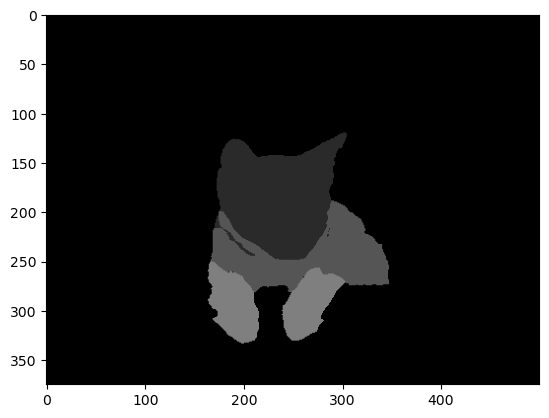

In [7]:
# combine masks for training
mixed_mask = mask1*1+mask2*2+mask3*3 #+mask4*4

# This is an image multi-segmentation task. The classes are:
    # 1: Head
    # 2: Body
    # 3: Legs
    # 4: Tail
# As seen below (notice this image does not include a tail in the image so no class 4)
print(np.unique(mixed_mask))

## For visualization purposes only, we can see the different segments colorcoded in the mixed mask by dividing my the sum of the class values (normalization)
## However, for submission, you should split the mask into 4 binary masks and RLE encode them individually as shown below.

plt.imshow(mixed_mask/6) # normalized just to show different segmentations (divide by sum of values)

### Training Pipeline

In [8]:
import keras 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

In [9]:
### START CODE HERE ###
import pandas as pd
import cv2
from PIL import Image
import random

## Data Pipeline
tr_DF = pd.read_csv("/kaggle/input/Multiclass-segmentation/train.csv")
test_DF = pd.read_csv("/kaggle/input/Multiclass-segmentation/test_class.csv")

tr_DF['ImagePath'] = '/kaggle/input/Multiclass-segmentation/TrainImages/' + tr_DF['ImageName'].astype(str) + '.jpg'
test_DF['ImagePath'] = '/kaggle/input/Multiclass-segmentation/TestImages/' + test_DF['ImageName'].astype(str) + '.jpg'

Unique_imgs = tr_DF['ImageName'].unique()
random.shuffle(Unique_imgs)
ratio = int(0.2 * len(Unique_imgs))

val_DF = tr_DF[tr_DF['ImageName'].isin(Unique_imgs[-ratio:])]
tr_DF = tr_DF[tr_DF['ImageName'].isin(Unique_imgs[:-ratio])]

## Data Generator
class Data_Generator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, DF, Imgs):
        self.batch_size = batch_size
        self.img_size = (256, 256)
        self.data = DF
        self.imgs = Imgs
        self.DF = pd.DataFrame()
        
    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        img_batch = self.imgs[i : i + self.batch_size]
        batch_data = self.data[self.data['ImageName'].isin(img_batch)]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j in range(len(img_batch)):
            masks = []
            img_masks = batch_data[batch_data['ImageName']==img_batch[j]]
            img = Image.open(img_masks['ImagePath'].iloc[0]).convert('RGB')
            img = img.resize(self.img_size)
            x[j, :, :, :] = np.array(img) / 255.
            for i in range(len(img_masks)):
                mask = decode_rle_to_mask(img_masks['Encoding'].iloc[i], img_masks['ImageHeight'].iloc[i], img_masks['ImageWidth'].iloc[i])*img_masks['ClassNumber'].iloc[i]
                mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
                masks.append(mask)
            mask = np.sum(masks, axis=0)
            y[j, :, :, 0] = mask[:, :, 0]
        return x, y

batch_size = 32
train_gen = Data_Generator(batch_size, tr_DF, Unique_imgs[:-ratio])
val_gen = Data_Generator(batch_size, val_DF, Unique_imgs[-ratio:])
#test_gen = Test_Generator(batch_size, test_DF, test_DF['ImageName'].unique())

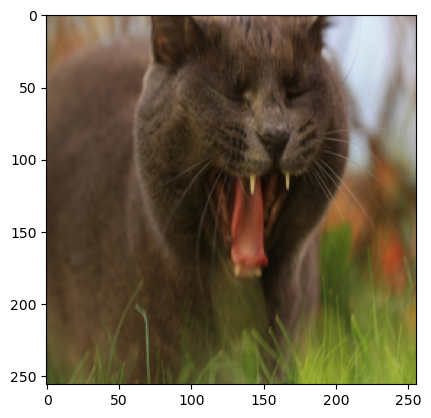

In [10]:
plt.imshow(val_gen[0][0][2])

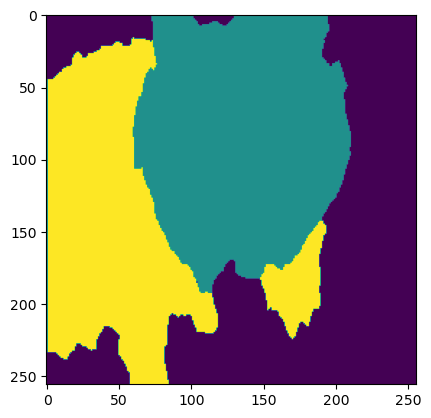

In [11]:
plt.imshow(val_gen[0][1][2][:,:,0])

In [12]:
!pip install segmentation-models

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.0 MB/s eta 0:00:00


In [13]:
## UNet_V2

## Model Design
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
import segmentation_models as sm

def U_Netv2(input_shape, num_classes):
    # Define the input layer
    inputs = Input(input_shape)

    # Encoding path
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoding path
    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = tf.keras.layers.concatenate([conv3, up5], axis=3)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = tf.keras.layers.concatenate([conv2, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = tf.keras.layers.concatenate([conv1, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    output = tf.keras.layers.Conv2D(num_classes, 1)(conv7)

    # Create and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model


Segmentation Models: using `keras` framework.


In [18]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [31]:
input_shape = (256, 256, 3)
num_classes = 5
# model = U_Netv2(input_shape, num_classes)
#!pip install segmentation-models
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam

model = U_Netv2(input_shape, num_classes=num_classes)

import tensorflow as tf
import segmentation_models as sm

def iou_score(y_true, y_pred):
    """
    Calculates the IOU score with class weights between the true and predicted labels.

    Args:
        y_true: The true labels, as a tensor of shape [batch_size, height, width, num_classes].
        y_pred: The predicted labels, as a tensor of shape [batch_size, height, width, num_classes].

    Returns:
        The IOU score with class weights, as a scalar tensor.
    """
    class_weight = tf.constant([0.04, 0.24, 0.24, 0.24, 0.24], dtype=tf.float32)
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.squeeze(y_true, axis=-1)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)

    iou = []
    for i in range(num_classes):
        y_true_i = tf.cast(tf.equal(y_true, i), tf.float32)
        y_pred_i = tf.cast(tf.equal(y_pred, i), tf.float32)

        intersection = tf.reduce_sum(y_true_i * y_pred_i, axis=[1, 2])
        union = tf.reduce_sum(tf.maximum(y_true_i, y_pred_i), axis=[1, 2])

        iou_i = tf.divide(intersection, union + tf.keras.backend.epsilon())
        iou.append(iou_i)

    iou = tf.stack(iou, axis=-1)

    # Apply class weights
    iou = tf.multiply(iou, class_weight)

    # Calculate the mean IOU score across the batch
    iou = tf.reduce_mean(iou)

    return iou


def f1_score(y_true, y_pred):
    """
    Calculates the F1 score with class weights between the true and predicted labels.

    Args:
        y_true: The true labels, as a tensor of shape [batch_size, height, width, num_classes].
        y_pred: The predicted labels, as a tensor of shape [batch_size, height, width, num_classes].

    Returns:
        The F1 score with class weights, as a scalar tensor.
    """
    class_weight = tf.constant([0.04, 0.24, 0.24, 0.24, 0.24], dtype=tf.float32)
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.squeeze(y_true, axis=-1)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)

    f1 = []
    for i in range(num_classes):
        y_true_i = tf.cast(tf.equal(y_true, i), tf.float32)
        y_pred_i = tf.cast(tf.equal(y_pred, i), tf.float32)

        true_positives = tf.reduce_sum(y_true_i * y_pred_i, axis=[1, 2])
        false_positives = tf.reduce_sum((1 - y_pred_i) * y_pred_i, axis=[1, 2])
        false_negatives = tf.reduce_sum(y_true_i * (1 - y_pred_i), axis=[1, 2])
        precision = tf.divide(true_positives, true_positives + false_positives + tf.keras.backend.epsilon())
        recall = tf.divide(true_positives, true_positives + false_negatives + tf.keras.backend.epsilon())

        f1_i = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        f1.append(f1_i)

    f1 = tf.stack(f1, axis=-1)

    # Apply class weights
    f1 = tf.multiply(f1, class_weight)

    # Calculate the mean F1 score across the batch
    f1 = tf.reduce_mean(f1)

    return f1

    
def loss(y_true, y_pred):
    """
    Calculates the weighted sparse categorical cross-entropy loss between the true and predicted labels.

    Args:
        y_true: The true labels, as a tensor of shape [batch_size, height, width, num_classes].
        y_pred: The predicted labels, as a tensor of shape [batch_size, height, width, num_classes].

    Returns:
        The weighted sparse categorical cross-entropy loss, as a scalar tensor.
    """
    class_weight = tf.constant([0.04, 0.24, 0.24, 0.24, 0.24], dtype=tf.float32)
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.squeeze(y_true, axis=-1)
    y_pred = tf.math.softmax(y_pred, axis=-1)
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Calculate the cross-entropy loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

    # Apply the class weights
    weights = tf.gather(class_weight, y_true)
    loss = tf.multiply(loss, weights)

    # Calculate the mean loss across the batch
    loss = tf.reduce_mean(loss)

    return loss
# class_weight = tf.constant([1.0, 2.25, 2.25, 2.25, 2.25], dtype=tf.float32)  # Example class weights
# weighted_scce_loss = WeightedSCCE(class_weight)
# Compile the model with the weighted loss function
model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss, metrics=[iou_score, f1_score])#sm.metrics.IOUScore(threshold=0.5, class_indexes = None), sm.metrics.FScore(threshold=0.5)])

#model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[sm.metrics.IOUScore(threshold=0.5, class_indexes = None), sm.metrics.FScore(threshold=0.5)])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_144 (Conv2D)            (None, 256, 256, 64  1792        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_145 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_144[0][0]']             
                                )                                                           

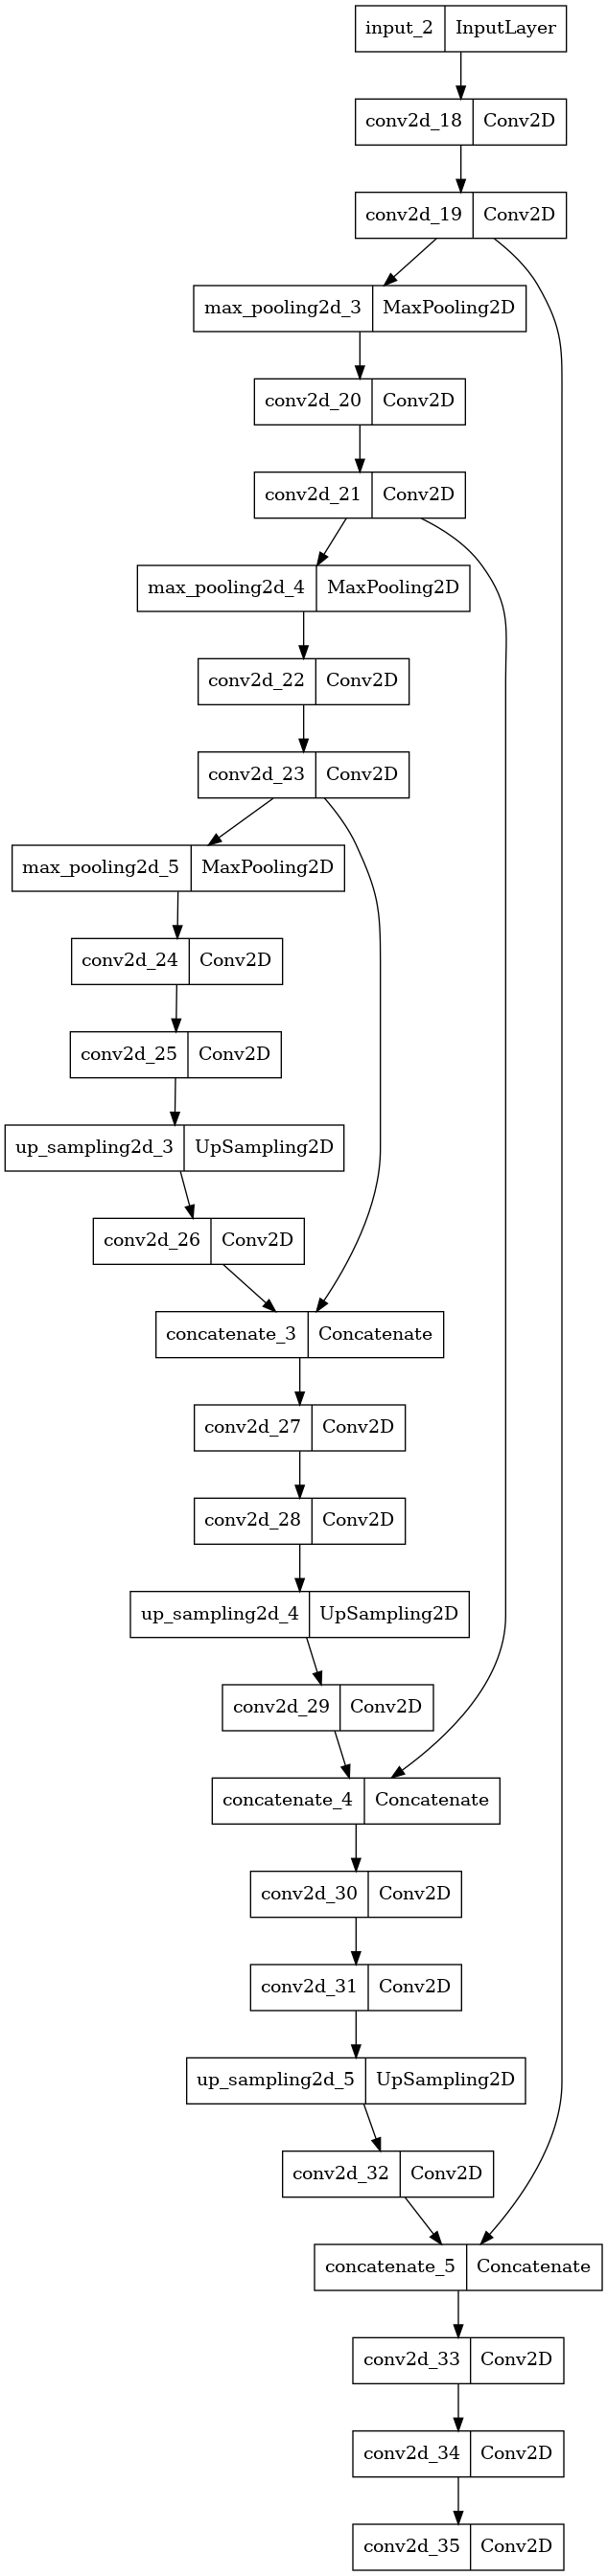

In [46]:
## Plot Model Archeticture
tf.keras.utils.plot_model(model, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [25]:
from tqdm import tqdm 
class Evaluate(tf.keras.callbacks.Callback):
    def __init__(self, val_data_gen):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.val_data    = val_data_gen
        #self.model = model

    ## IOU
    def calculate_iou(self, y_true, y_pred):
        results = []
        for i in range(0,y_true.shape[0]):

            # set the types so we are sure what type we are using
            y_true = y_true.astype(np.float32)
            y_pred = y_pred.astype(np.float32)


            # boxTrue
            x_boxTrue_tleft = y_true[0,0]  # numpy index selection
            y_boxTrue_tleft = y_true[0,1]
            boxTrue_width = y_true[0,2]
            boxTrue_height = y_true[0,3]
            area_boxTrue = (boxTrue_width * boxTrue_height)

            # boxPred
            x_boxPred_tleft = y_pred[0,0]
            y_boxPred_tleft = y_pred[0,1]
            boxPred_width = y_pred[0,2]
            boxPred_height = y_pred[0,3]
            area_boxPred = (boxPred_width * boxPred_height)


            # calculate the bottom right coordinates for boxTrue and boxPred

            # boxTrue
            x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
            y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

            # boxPred
            x_boxPred_br = x_boxPred_tleft + boxPred_width
            y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


            # calculate the top left and bottom right coordinates for the intersection box, boxInt

            # boxInt - top left coords
            x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
            y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

            # boxInt - bottom right coords
            x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
            y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

            # Calculate the area of boxInt, i.e. the area of the intersection 
            # between boxTrue and boxPred.
            # The np.max() function forces the intersection area to 0 if the boxes don't overlap.


            # Version 2 revision
            area_of_intersection = \
            np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

            iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


            # This must match the type used in py_func
            iou = iou.astype(np.float32)

            # append the result to a list at the end of each loop
            results.append(iou)

        # return the mean IoU score for the batch
        return np.mean(results)

    def IoU(self, y_true, y_pred):
        # Note: the type float32 is very important. It must be the same type as the output from
        # the python function above or you too may spend many late night hours 
        # trying to debug and almost give up.

        iou = round(float(self.calculate_iou(np.squeeze(y_true), y_pred),2))

        return iou
        
    def on_epoch_end(self, epoch, logs=None):
        Batch_IOU = []
        for i in tqdm(range(len(self.val_data))):
            y_pred = self.model.predict(self.val_data[i][0]) 
            batch_IOU = self.IoU(self.val_data[i][1], y_pred)
            Batch_IOU.extend(batch_IOU)
        
        return sum(Val_IOU) / len(Val_IOU)

In [32]:
## Training

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_iou_score', min_delta=0, patience=7, verbose=1, mode='auto')
checkpoint = ModelCheckpoint(filepath="/kaggle/working/Animal_Segmentation_UNet.h5", 
                            monitor='val_iou_score', 
                            verbose=1, 
                            save_best_only=True, 
                            mode='max')

#Evaluator = Evaluate(val_gen)
callbacks = [checkpoint, early_stop]

# Train the model, doing validation at the end of each epoch.
epochs = 50
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 0.0782 - iou_score: 0.0074 - f1_score: 0.0101
Epoch 1: val_iou_score improved from -inf to 0.00730, saving model to /kaggle/working/Animal_Segmentation_UNet.h5
169/169 [==============================] - 169s 990ms/step - loss: 0.0782 - iou_score: 0.0074 - f1_score: 0.0101 - val_loss: 0.0731 - val_iou_score: 0.0073 - val_f1_score: 0.0080
Epoch 2/50
169/169 [==============================] - ETA: 0s - loss: 0.0740 - iou_score: 0.0073 - f1_score: 0.0080
Epoch 2: val_iou_score did not improve from 0.00730
169/169 [==============================] - 165s 980ms/step - loss: 0.0740 - iou_score: 0.0073 - f1_score: 0.0080 - val_loss: 0.0731 - val_iou_score: 0.0073 - val_f1_score: 0.0080
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 0.0740 - iou_score: 0.0073 - f1_score: 0.0080
Epoch 3: val_iou_score did not improve from 0.00730
169/169 [==============================] - 165s 977ms/step - loss: 0.0740 - 

In [24]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["iou_score"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["f1-score"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_iou_score"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_f1-score"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

NameError: name 'history' is not defined

In [22]:
## TESTING
from keras.models import load_model
import segmentation_models as sm

# Load the model from file
loaded_model = load_model('/kaggle/working/Animal_Segmentation_UNet.h5', custom_objects={"iou_score": sm.metrics.IOUScore(threshold=0.5, class_indexes = None), "f1-score": sm.metrics.FScore(threshold=0.5)})
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions
#Outputs = infer(loaded_model, x)

Segmentation Models: using `keras` framework.


In [24]:
from tqdm import tqdm
import numpy as np
from PIL import Image
pass_test = []
x = np.zeros((len(test_DF['ImagePath'].values.tolist()),) + (256,256) + (3,), dtype="float32")
for i, img in tqdm(enumerate(test_DF['ImagePath'].values.tolist())):
    img = Image.open(img).convert('RGB')
    img = img.resize((256,256))
    img = np.array(img) / 255.
    Output = infer(loaded_model, img)
    if Output[Output>0].size != 0:
        #print(Output[Output>0])
        pass_test.append(Output)

3088it [03:50, 13.41it/s]


In [25]:
print(len(test_DF))
len(pass_test)

3088


3088

In [82]:
Output = model.predict(np.expand_dims(img, axis=0))
Output = Output.argmax(-1)

1/1 [==============================] - 0s 19ms/step


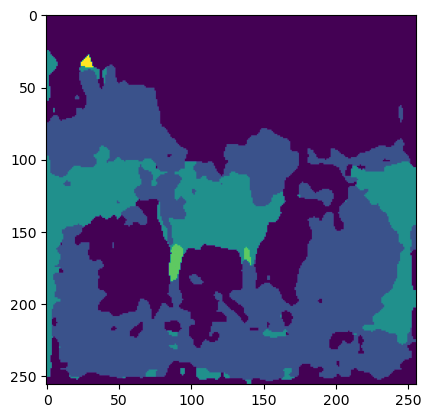

In [53]:
import matplotlib.pyplot as plt
plt.imshow(pass_test[500cv0] l24, [jm])
plt.show()

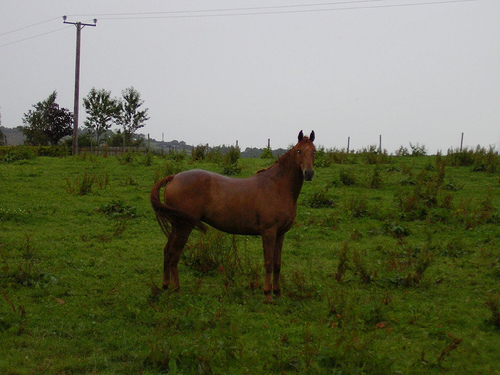

In [54]:
Image.open(test_DF['ImagePath'].iloc[500])

### Encoding masks into RLE for submission

In [23]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [26]:
# IMPORTANT || Convert mask to grayscale
mask1 = mask1[:,:,0] # or using other methods depending on mask
mask1.shape

(375, 500)

In [27]:
rle = encode_mask_to_rle(mask1)
rle

'60302 3 60799 7 61297 9 61796 10 62294 12 62793 12 63191 1 63290 15 63689 9 63789 16 64187 13 64286 18 64686 16 64784 20 65185 18 65281 22 65684 20 65780 23 66183 22 66279 23 66683 23 66777 25 67182 25 67275 27 67682 25 67774 27 68181 27 68272 26 68680 29 68770 27 69180 30 69268 29 69680 30 69765 31 70180 31 70263 33 70679 33 70762 33 71179 34 71260 35 71679 35 71726 16 71756 39 72178 37 72219 76 72678 116 73178 115 73678 115 74178 115 74678 116 75178 116 75678 116 76179 115 76679 114 77179 113 77679 113 78177 115 78676 116 79176 116 79675 117 80175 117 80675 118 81175 118 81675 118 82175 118 82675 118 83174 118 83674 118 84174 118 84674 118 85174 118 85674 118 86174 117 86674 116 87174 116 87674 115 88174 115 88674 115 89174 114 89675 113 90175 113 90675 113 91175 114 91675 114 92175 114 92675 115 93176 114 93676 114 94177 113 94677 113 95177 113 95677 113 96177 112 96677 112 97178 111 97678 111 98178 111 98678 110 99177 111 99677 110 100181 105 100682 104 101182 104 101683 103 10217